In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from compass_analysis import cohens_d, wilcoxon_test, get_reaction_consistencies, get_metareactions, \
labeled_reactions, amino_acid_metab

# Load Compass running output

In [3]:
cell_metadata = pd.read_csv("../metadata/labeled_neutrophil_merged_metadata_1209.csv", index_col=0)
reaction_penalties = pd.read_csv("../metadata/compass/reactions.tsv", sep="\t", index_col=0)

In [4]:
reaction_metadata = pd.read_csv("~/software/other_packages/Compass/notebooks/extdata/RECON2/reaction_metadata.csv",
                                index_col = 0)

In [5]:
reaction_penalties.columns = reaction_penalties.columns.str.replace('\\.','-')

<ipython-input-5-56fa708446ce>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  reaction_penalties.columns = reaction_penalties.columns.str.replace('\\.','-')


In [6]:
Special_neu_cells = cell_metadata.index[cell_metadata['on_interest'] == 1]
Normal_neu_cells = cell_metadata.index[cell_metadata['on_interest'] == 0]

In [7]:
reaction_consistencies = get_reaction_consistencies(reaction_penalties)
wilcox_results = wilcoxon_test(reaction_consistencies, Special_neu_cells, Normal_neu_cells)
wilcox_results['metadata_r_id'] = ""
for r in wilcox_results.index:
    if r in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")

In [8]:
W = wilcox_results.merge(reaction_metadata, how='left',
                         left_on='metadata_r_id', right_index=True, validate='m:1')
W = W[W['confidence'].isin([0,4])]
W = W[~W['EC_number'].isna()]
W.loc[(W['formula'].map(lambda x: '[m]' not in x)) & (W['subsystem'] == "Citric acid cycle"), 'subsystem'] = 'Other'

# Differential analysis

In [9]:
def plot_differential_scores(data, title, c, figsize=(10,10)):
    plt.figure(figsize=figsize)
    axs = plt.gca()
    axs.scatter(data['cohens_d'], -np.log10(data['adjusted_pval']), c=c)
    axs.set_xlabel("Cohen's d", fontsize=16)
    axs.set_ylabel("-log10 (Wilcoxon-adjusted p)", fontsize=16)
    #Everything after this should be tweaked depending on your application
    axs.set_xlim(-2.2, 2.2)
    axs.axvline(0, dashes=(3,3), c='black')
    axs.axhline(1, dashes=(3,3), c='black')
    axs.set_title(title, fontdict={'fontsize':20})
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(0, -0.08),
            arrowprops=dict(arrowstyle="<-", color='#348C73', linewidth=4))
    axs.annotate('Special Neu', xy=(0.75, -0.12), xycoords='axes fraction', fontsize=16)
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(1, -0.08),
            arrowprops=dict(arrowstyle="<-", color='#E92E87', linewidth=4))
    axs.annotate('Normal Neu', xy=(0.25, -0.12), xycoords='axes fraction', fontsize=16)
    for r in data.index:
        if r in labeled_reactions:
            x = data.loc[r, 'cohens_d']
            y = -np.log10(data.loc[r, 'adjusted_pval'])
            offset = (20, 0)
            if x < 0:
                offset = (-100, -40)
            axs.annotate(labeled_reactions[r], (x,y), xytext = offset,
                         textcoords='offset pixels', arrowprops={'arrowstyle':"-"})

In [10]:
labeled_reactions = {}

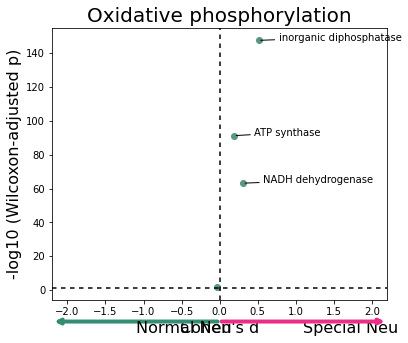

In [11]:
labeled_reactions['ATPS4m_pos'] = 'ATP synthase'
labeled_reactions['NADH2_u10m_pos'] = 'NADH dehydrogenase'
labeled_reactions['PPAm_pos'] = 'inorganic diphosphatase'

data = W[W['subsystem'] == "Oxidative phosphorylation"]
plot_differential_scores(data, title='Oxidative phosphorylation', c="#59987e", figsize=(6,5))

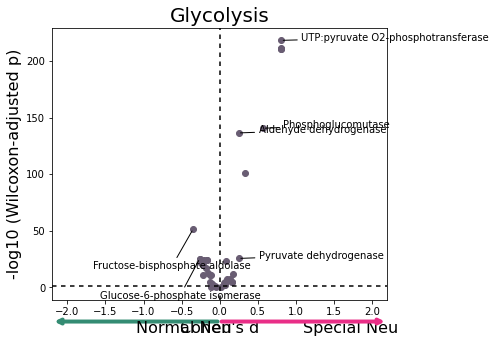

In [12]:
labeled_reactions['FBA_neg'] = 'Fructose-bisphosphate aldolase'
labeled_reactions['PGI_pos'] = 'Glucose-6-phosphate isomerase'
labeled_reactions['r0165_pos'] = 'UTP:pyruvate O2-phosphotransferase'
labeled_reactions['PDHm_pos'] = 'Pyruvate dehydrogenase'
labeled_reactions['PGMT_neg'] = 'Phosphoglucomutase'
labeled_reactions['ALDD2xm_pos'] = 'Aldehyde dehydrogenase'

data = W[W['subsystem'] == "Glycolysis/gluconeogenesis"]
plot_differential_scores(data, title='Glycolysis', c="#695D73", figsize=(6,5))

In [13]:
labeled_reactions['ICDHxm_pos'] = 'Isocitrate dehydrogenase (NAD+)'
labeled_reactions['CSm_pos'] = 'Citrate synthase'
labeled_reactions['MDHm_neg'] = 'Malate dehydrogenase'
labeled_reactions['ICDHyrm_neg'] = 'Isocitrate dehydrogenase (NADP+)'

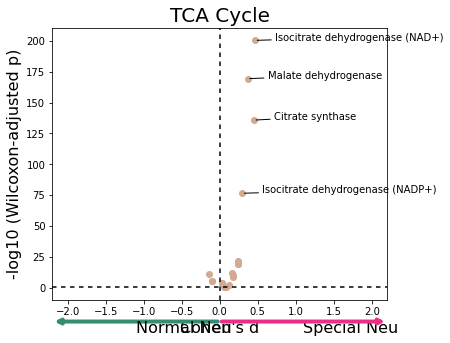

In [14]:
data = W[W['subsystem'] == "Citric acid cycle"]
plot_differential_scores(data, title="TCA Cycle", c="#D3A991", figsize=(6,5))

<Figure size 144x144 with 0 Axes>

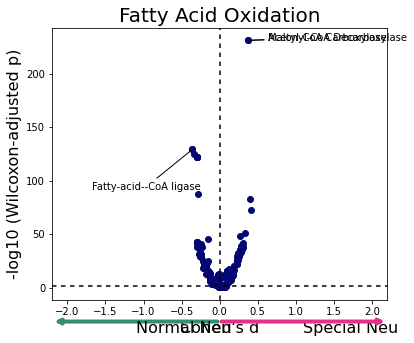

In [15]:
labeled_reactions['ACCOACm_pos'] = 'Acetyl-CoA Carboxylase'
labeled_reactions['MCDm_pos'] = 'Malonyl-CoA Decarboxylase'
labeled_reactions['FACOAL1831_neg'] = 'Fatty-acid--CoA ligase'

data = W[W['subsystem'] == "Fatty acid oxidation"]
plt.figure(figsize=(2,2))
plot_differential_scores(data, "Fatty Acid Oxidation", c="#040772", figsize=(6,5))

In [16]:
reaction_consistencies.to_csv('../metadata/reaction_consistencies_0313.csv')

In [17]:
filtered_data = pd.concat([W[W['subsystem'] == "Glycolysis/gluconeogenesis"],
                           W[W['subsystem'] == "Citric acid cycle"],
                           W[W['subsystem'] == "Oxidative phosphorylation"],
                           W[W['subsystem'] == "Fatty acid oxidation"]])
filtered_data.to_csv('../metadata/compass_filtered_0313.csv')